## Exploring the HAR Dataset & Understanding RNNs

---

### **1. Sequence Learning with Recurrent Neural Networks (RNNs)**

This module marks the beginning of **Unit 2: Sequence Models**, where we shift from images and structured data (Modules 1–6) to **temporal and sequential data**.  
We will learn how neural networks can process data that evolves over time, such as sensor readings, text, or financial series.  

In this project, we use the **UCI Human Activity Recognition (HAR) Dataset**, where smartphone motion sensors capture human activities like walking, sitting, and standing.  
Our goal is to build and explore **Recurrent Neural Networks (RNNs)** to classify these activities.

**Lesson Objectives**
By the end of this notebook, we will:  
- Understand what sequential data is and why time structure matters.  
- Explore the **HAR dataset** and prepare it for modeling.  
- Learn how **RNNs process input sequences** step by step.  
- Set up input sequences in the correct PyTorch format for RNNs.  
- Build intuition for how hidden states evolve during sequence processing.  

**Topics to be Covered**  
1. Introduction to sequential data and time dependence.  
2. The structure of the UCI HAR dataset.  
3. Preparing data tensors for PyTorch RNNs.  
4. Basics of RNN architecture and hidden state propagation.  
5. Visualization of sample activity sequences.  

**Connections to Previous Modules (1–6)**
Before diving into RNNs, let’s briefly recall key building blocks we’ve already mastered:  
- **Tensors and PyTorch basics** (Module 1).  
- **Linear regression and gradient descent** (Module 1).  
- **Activation functions and non-linearity** (Module 1).  
- **Feedforward neural networks (FNNs)** and **backpropagation** (Modules 2–3).  
- **Training and optimization techniques** (Module 3).  
- **Convolutional Neural Networks (CNNs)** for image data (Modules 4–6).  

These foundations will help us understand how RNNs extend neural networks to handle **ordered, time-dependent data**.

**References**  
- UCI HAR Dataset: [Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones)  
- Goodfellow et al. (2016), *Deep Learning*, MIT Press – Chapter on Sequence Models  
- PyTorch Documentation: [Recurrent Layers](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)  

---


### **2. Human Activity Recognition (HAR)**

Human Activity Recognition (HAR) is about **classifying physical activities** (like walking, standing, sitting) from sensor signals collected by wearable devices such as smartphones or smartwatches.  

In this project, we will use the **UCI HAR dataset**, where:  
- 📱 A Samsung Galaxy S II smartphone was worn at the waist.  
- 👥 30 volunteers performed **6 activities**:  
  - WALKING  
  - WALKING_UPSTAIRS  
  - WALKING_DOWNSTAIRS  
  - SITTING  
  - STANDING  
  - LAYING  
- 📡 The smartphone recorded **accelerometer** (linear acceleration) and **gyroscope** (angular velocity) signals at **50 Hz** (50 readings per second).  

**Data representation**

Each activity segment was preprocessed into **windows of 2.56 seconds** (≈ 128 timesteps).  

- Each window contains:  
  - **9 raw signals** (3 axes each for *total acceleration*, *body acceleration*, and *gyroscope*).  
  - This gives us an input shape of **128 × 9** (128 timesteps × 9 features).  
- Each window is assigned **one label** (the activity being performed).  

So one training example looks like this:

$$
X \in \mathbb{R}^{128 \times 9}, \quad y \in \{1,2,3,4,5,6\}
$$



**Why does the time structure matter?**

Let’s compare three types of models:

- **MLP** (Fully Connected Network)
  - Treats inputs as a flat vector.  
  - Ignores order of timesteps.  
  - Example: Flatten $(128 \times 9) \to 1152$ features.  

- **CNN** (Convolutional Neural Network)  
  - Captures local patterns (sliding filters).  
  - Great for spatial data (like images).  
  - With 1D filters, CNNs can capture short-term dependencies, but not long-term memory.  

- **RNN** (Recurrent Neural Network) 
  - Processes inputs **sequentially**:  
    - At timestep $t$, it uses the current input $x_t$ *and* the hidden state $h_{t-1}$ from the past.  
    - This allows the model to **remember history** and capture temporal dynamics.  

 


**RNN core idea (high level)**

At each timestep $t$:

$$
h_t = f(W_{xh} x_t + W_{hh} h_{t-1} + b_h)
$$

- $x_t$ = input at time $t$ (9 features in our case).  
- $h_{t-1}$ = hidden state from previous timestep.  
- $h_t$ = updated hidden state (the model’s memory at $t$).  

At the end of the sequence ($t = 128$):

$$
\hat{y} = \text{softmax}(W_{hy} h_{128} + b_y)
$$

This gives us the predicted activity (one of the 6 classes). 


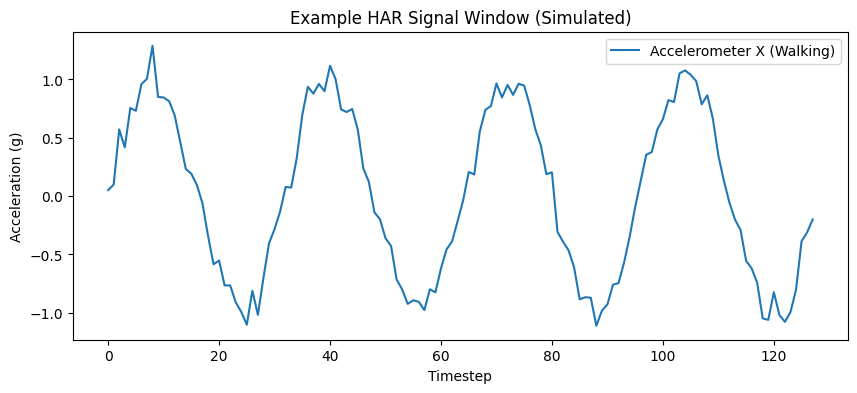

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# For now, simulate one sequence for demonstration.
# Later we will replace with real HAR data.
timesteps = np.arange(128)
signal = np.sin(2 * np.pi * timesteps / 32) + 0.1 * np.random.randn(128)

plt.figure(figsize=(10,4))
plt.plot(timesteps, signal, label="Accelerometer X (Walking)")
plt.xlabel("Timestep")
plt.ylabel("Acceleration (g)")
plt.title("Example HAR Signal Window (Simulated)")
plt.legend()
plt.show()

### **3. Data Exploration & Preprocessing**

**What files do we have?**

The HAR dataset comes with **raw inertial signals** for each windowed segment (2.56s ≈ 128 timesteps). For each split (`train/` and `test/`), we have nine text files under `Inertial Signals/`, plus label files:

- **Signals (each row = one 128-timestep window)**  
  - `body_acc_x_[split].txt`, `body_acc_y_[split].txt`, `body_acc_z_[split].txt`  
  - `total_acc_x_[split].txt`, `total_acc_y_[split].txt`, `total_acc_z_[split].txt`  
  - `body_gyro_x_[split].txt`, `body_gyro_y_[split].txt`, `body_gyro_z_[split].txt`  

- **Labels**  
  - `y_[split].txt` → activity label for each window (integers in $\{1,\dots,6\}$).  
  - (Optional) `subject_[split].txt` → subject ID (1–30) for each window.

Each signal file has shape **(N, 128)**. Stacking the 9 channels gives us a **multivariate sequence** of shape **$(N, 128, 9)$**.

> One sample (one window) therefore looks like: $X \in \mathbb{R}^{128 \times 9}$ with a single label $y \in \{1,2,3,4,5,6\}$.

**What does “preprocessing” mean here?**

We’ll do a few minimal, transparent steps:

1. **Load** the nine signals per split and **stack** them along the last axis to get $(N, 128, 9)$.
2. **Load labels** as integers (we’ll also show **one-hot encoding** for pedagogy, even though PyTorch’s `CrossEntropyLoss` expects class indices, not one-hot).
3. **Normalize** features (optional but recommended): compute **per-channel** mean/std on the **training set only**, and standardize both train and test:
   $$
   X' = \frac{X - \mu_{\text{train}}}{\sigma_{\text{train}} + \epsilon}
   $$
   This keeps magnitudes comparable across channels and helps stable training on CPU.
4. **Prepare tensors** for PyTorch and preview a couple of examples.

**Quick note on one-hot vs. class indices**

- **Class indices** (0–5) are what `nn.CrossEntropyLoss` expects.  
- **One-hot vectors** (length 6) are useful for metrics/plots or if we ever use `nn.BCEWithLogitsLoss` in a multi-label setup.  
We’ll keep **class indices** as our ground truth and optionally show how to get one-hot when needed.

**Visual sanity checks**

We’ll:
- Print shapes (`(N, 128, 9)` for inputs, `(N,)` for labels).
- Show the **first window** as a small matrix preview and its label name.
- Plot short **sequence snippets** for two activities (e.g., **WALKING** vs **SITTING**) to build intuition about temporal patterns.

**Preparing shapes for RNNs**

Our DataLoaders will typically yield **batch-first** `(batch, seq_len, input_size)` = `(B, 128, 9)`.  
PyTorch’s `nn.RNN` by default expects **time-first** tensors:
$$
(\text{seq\_len}, \text{batch}, \text{input\_size}) = (128, B, 9).
$$
We’ll use `x.permute(1, 0, 2)` before the forward pass (or set `batch_first=True` in the RNN if we prefer batch-first).




Dataset Download Link: https://www.kaggle.com/datasets/drsaeedmohsen/ucihar-dataset/data

In [3]:
# Imports & config for this section

import os
from pathlib import Path
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Update this path to point to your extracted "UCI HAR Dataset" folder
BASE_DIR = Path("UCI HAR Dataset")  
assert BASE_DIR.exists(), f"BASE_DIR does not exist: {BASE_DIR}"

ACTIVITY_MAP = {
    1: "WALKING",
    2: "WALKING_UPSTAIRS",
    3: "WALKING_DOWNSTAIRS",
    4: "SITTING",
    5: "STANDING",
    6: "LAYING",
}
NUM_CLASSES = 6


In [4]:
# Loader for the 9-channel raw inertial signals + labels

SIGNAL_NAMES = [
    "body_acc_x", "body_acc_y", "body_acc_z",
    "total_acc_x","total_acc_y","total_acc_z",
    "body_gyro_x","body_gyro_y","body_gyro_z",
]

def load_split(split="train", base_dir=BASE_DIR):
    """
    Returns:
        X: np.ndarray, shape (N, 128, 9)
        y: np.ndarray, shape (N,) with class indices in {0..5}
        subjects: np.ndarray, shape (N,) with subject IDs (1..30)
    """
    sig_dir = base_dir / split / "Inertial Signals"
    matrices = []
    for name in SIGNAL_NAMES:
        fpath = sig_dir / f"{name}_{split}.txt"
        arr = np.loadtxt(fpath, dtype=np.float32)  # shape: (N, 128)
        matrices.append(arr[:, :, None])           # -> (N, 128, 1)

    X = np.concatenate(matrices, axis=2)          # (N, 128, 9)
    y = np.loadtxt(base_dir / split / f"y_{split}.txt", dtype=np.int64)
    y = y - 1  # convert {1..6} -> {0..5}
    subjects = np.loadtxt(base_dir / split / f"subject_{split}.txt", dtype=np.int64)
    return X, y, subjects

X_train_np, y_train_np, subj_train = load_split("train", BASE_DIR)
X_test_np,  y_test_np,  subj_test  = load_split("test",  BASE_DIR)

print("Train X shape:", X_train_np.shape, "(N, 128, 9)")
print("Train y shape:", y_train_np.shape,  "(N,)  class indices in {0..5}")
print("Test  X shape:", X_test_np.shape)
print("Test  y shape:", y_test_np.shape)
print("Unique train labels:", np.unique(y_train_np))


Train X shape: (7352, 128, 9) (N, 128, 9)
Train y shape: (7352,) (N,)  class indices in {0..5}
Test  X shape: (2947, 128, 9)
Test  y shape: (2947,)
Unique train labels: [0 1 2 3 4 5]


In [5]:

# Optional: per-channel standardization using TRAIN statistics

EPS = 1e-8 # 1e-8 to avoid division by zero

# Compute mean/std over (N, T) for each of the 9 channels on TRAIN only
# X_train_np: (N, 128, 9)
train_mean = X_train_np.mean(axis=(0,1), keepdims=True)  # shape (1,1,9)
# axis(0,1) means "collapse N and T, keep channels" and get mean/std per channel. keepdims=True keeps the 3D shape for broadcasting
# axis=0 would collapse N only, giving (1, 128, 9) mean per timestep
# axis=1 would collapse T only, giving (N, 1, 9) mean per sample
# axis=2 would collapse channels only, giving (N, 128, 1) mean per sample/timestep
# We want (1,1,9) to broadcast correctly when subtracting from (N,128,9)
# So we get one mean/std per channel over the entire TRAIN set

train_std  = X_train_np.std(axis=(0,1),  keepdims=True)  # shape (1,1,9)

X_train_std = (X_train_np - train_mean) / (train_std + EPS)
X_test_std  = (X_test_np  - train_mean) / (train_std + EPS)  # use train stats!

print("Per-channel mean (train):", train_mean.reshape(-1)[:3], "... (showing first 3)")
print("Per-channel std  (train):", train_std.reshape(-1)[:3],  "... (showing first 3)")


Per-channel mean (train): [-0.00063632 -0.0002923  -0.0002753 ] ... (showing first 3)
Per-channel std  (train): [0.19478364 0.12235899 0.10680177] ... (showing first 3)


In [6]:
# Convert to PyTorch tensors

X_train_t = torch.from_numpy(X_train_std)  # (N, 128, 9), float32
y_train_t = torch.from_numpy(y_train_np)   # (N,), int64

X_test_t  = torch.from_numpy(X_test_std)
y_test_t  = torch.from_numpy(y_test_np)

print(X_train_t.shape, y_train_t.shape, X_test_t.shape, y_test_t.shape)

torch.Size([7352, 128, 9]) torch.Size([7352]) torch.Size([2947, 128, 9]) torch.Size([2947])


In [7]:
# Dataset preview: show first sequence (a small slice) and its label name

def preview_sequence(X_np, y_np, index=0, timesteps_to_show=10):
    seq = X_np[index]  # (128, 9)
    label_idx = int(y_np[index])
    label_name = ACTIVITY_MAP[label_idx + 1]
    print(f"Sample index: {index}")
    print(f"Label index/name: {label_idx} / {label_name}")
    print(f"Sequence shape: {seq.shape} (timesteps, features)")
    print("First few timesteps (first 3 features):")
    print(seq[:timesteps_to_show, :3])  # show first 3 channels for brevity

preview_sequence(X_train_std, y_train_np, index=0, timesteps_to_show=8)


Sample index: 0
Label index/name: 4 / STANDING
Sequence shape: (128, 9) (timesteps, features)
First few timesteps (first 3 features):
[[0.00419526 0.09038245 0.5228001 ]
 [0.05531714 0.05616078 0.5187192 ]
 [0.05088666 0.07536164 0.45579797]
 [0.0292746  0.06359139 0.46862772]
 [0.05876554 0.05257694 0.40531576]
 [0.02403393 0.05914247 0.42138427]
 [0.02769068 0.03142163 0.41192463]
 [0.03516703 0.02312396 0.33383194]]


Example indices -> WALKING: 78  SITTING: 27


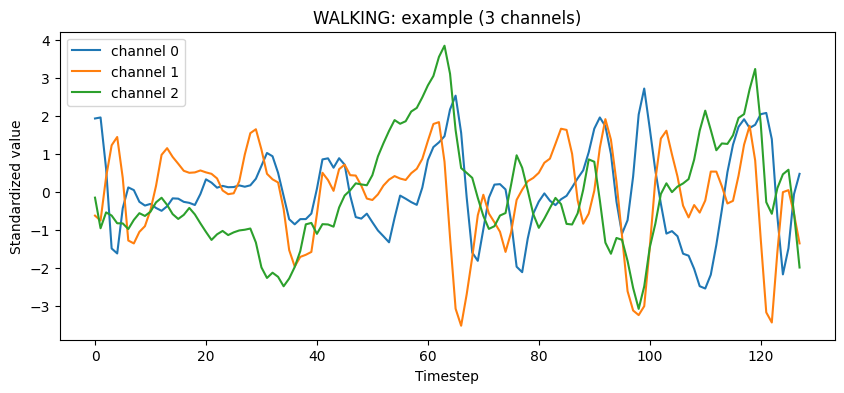

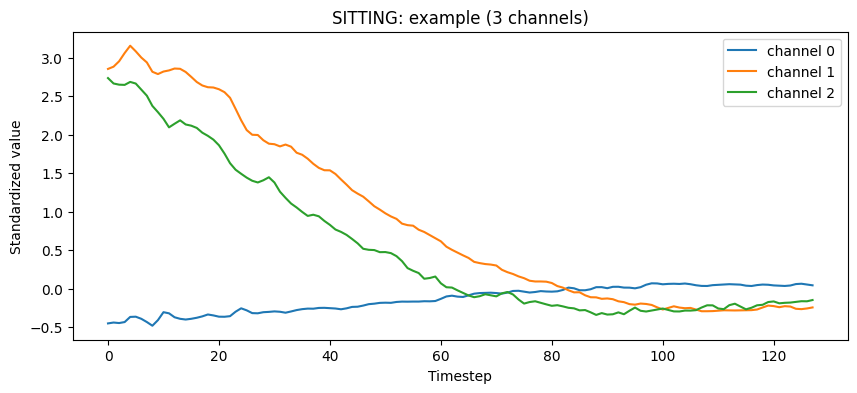

In [8]:
# Plot sample sequences for two activities: WALKING (1-> index 0) vs SITTING (4-> index 3)
# We'll plot 3 channels for clarity (e.g., body_acc_x/y/z)

def find_first_index(y_np, class_index):
    idxs = np.where(y_np == class_index)[0]
    return int(idxs[0]) if len(idxs) > 0 else None

idx_walk   = find_first_index(y_train_np, 0)  # WALKING -> 1 -> index 0
idx_sit    = find_first_index(y_train_np, 3)  # SITTING -> 4 -> index 3

print("Example indices -> WALKING:", idx_walk, " SITTING:", idx_sit)

def plot_three_channels(seq, title, channels=(0,1,2)):
    t = np.arange(seq.shape[0])  # 0..127
    plt.figure(figsize=(10,4))
    for c in channels:
        plt.plot(t, seq[:, c], label=f"channel {c}")
    plt.xlabel("Timestep")
    plt.ylabel("Standardized value")
    plt.title(title)
    plt.legend()
    plt.show()

if idx_walk is not None:
    plot_three_channels(X_train_std[idx_walk], "WALKING: example (3 channels)")

if idx_sit is not None:
    plot_three_channels(X_train_std[idx_sit], "SITTING: example (3 channels)")

**What did we observe?**

- **Shapes:** Inputs are $(N, 128, 9)$ — exactly what we expect for multivariate time series. Labels are $(N,)$ with class indices in $\{0..5\}$.  
- **Scaling:** Standardization puts channels on a comparable scale, which often stabilizes training and helps CPU convergence.  
- **Patterns:**  
  - Locomotion activities (e.g., **WALKING**) tend to show **oscillatory patterns** across time.  
  - Static activities (e.g., **SITTING**) tend to look **flatter**.  
- **One-hot vs indices:** We’ll train with **class indices** (what `CrossEntropyLoss` expects). We can still use one-hot vectors for plotting or analysis when convenient.

Next, we’ll use these tensors to **probe the mechanics of an RNN** in three steps:
1) Minimal scalar memory (`batch=1`, `hidden_size=1`),  
2) Small memory vector (`batch=1`, `hidden_size=3`),  
3) Realistic batch (`batch=32`, `hidden_size=32`) and **time-first vs batch-first** formatting for `nn.RNN`.

---


📘 Instruction</br>
Find the first index of class LAYING (label 5) in y_train_np, grab the corresponding standardized sequence from X_train_std (shape (128, 9)), and plot channels 0, 1, 2 over timesteps to visualize the signal pattern.


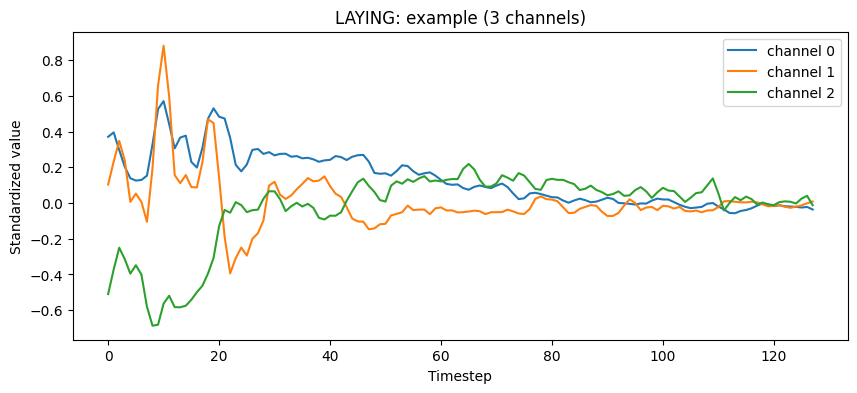

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Find first index of a target class in y_train_np (0..5). LAYING is index 5.
def CT_find_first_index(y_np, class_index):
    idxs = np.where(y_np == class_index)[0]
    return int(idxs[0]) if len(idxs) > 0 else None

CT_idx_laying = CT_find_first_index(y_train_np, 5)

# Pull standardized sequence (128, 9)
CT_seq_laying = X_train_std[CT_idx_laying]   # expect X_train_std

# Channels to show
CT_channels = (0, 1, 2)

# Plot
t = np.arange(CT_seq_laying.shape[0])
plt.figure(figsize=(10,4))
for c in CT_channels:
    plt.plot(t, CT_seq_laying[:, c], label=f"channel {c}")
plt.xlabel("Timestep")
plt.ylabel("Standardized value")
plt.title("LAYING: example (3 channels)")
plt.legend()
plt.show()


---

### **4. Case 1 – Minimal RNN (batch=1, hidden_size=1)**

**Why start simple?**

Before we scale up, let’s build intuition with the **simplest possible RNN**:

- **Batch size = 1**  
  → we only look at **one sequence** at a time.  
  → No parallelization, easier to “follow the story” of the hidden state.

- **Hidden size = 1**  
  → the hidden state is just a **single number**.  
  → Think of it as a tiny memory slot that gets updated at each timestep.  

This makes it very clear what happens at each step.

**The RNN equations (scalar case)**

At timestep $t$:

$$
h_t = \tanh(W_{xh} x_t + W_{hh} h_{t-1} + b_h)
$$

- $x_t$: input at timestep $t$ (a 9-dimensional vector).  
- $h_{t-1}$: the hidden state carried from the previous timestep (a scalar here).  
- $h_t$: the updated hidden state (still a scalar).  

At the end of the sequence ($t=128$), we use the last hidden state to make a prediction:

$$
\hat{y} = \text{softmax}(W_{hy} h_{128} + b_y)
$$

**Intuition**

- The RNN is like a **rolling summary** of everything seen so far.  
- At each timestep, the hidden state **compresses the past + current input** into one value.  
- By the end of 128 steps, the last hidden state $h_{128}$ represents the whole sequence.  

**What we will do**

1. Pick one sequence (e.g., the first training example).  
2. Feed it through an RNN with `hidden_size=1`.  
3. Print:  
   - a few $h_t$ values (to see how they evolve over time),  
   - the final hidden state $h_{128}$,  
   - the logits (before softmax),  
   - the probabilities (after softmax).  
4. Plot all $h_t$ values across time (a line chart).



In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 3.5 Select one sequence and one label
seq = X_train_t[0]       # shape (128, 9)
label = y_train_t[0].item()

print("Sequence shape:", seq.shape, "(timesteps=128, features=9)")
print("Label index:", label, "->", ACTIVITY_MAP[label+1])

# Reshape to (seq_len, batch, input_size)
seq_in = seq.unsqueeze(1)  # (128, 1, 9)
print("Input to RNN shape:", seq_in.shape)


Sequence shape: torch.Size([128, 9]) (timesteps=128, features=9)
Label index: 4 -> STANDING
Input to RNN shape: torch.Size([128, 1, 9])


In [11]:
# Define minimal RNN: input_size=9, hidden_size=1
rnn = nn.RNN(input_size=9, hidden_size=1, batch_first=False)

# Forward pass
out_seq, h_n = rnn(seq_in)   # out_seq: (128, 1, 1), h_n: (1, 1, 1)

# Classification head: hidden -> 6 classes
fc = nn.Linear(1, NUM_CLASSES)
logits = fc(h_n.squeeze(0))   # shape (1,6)
probs = F.softmax(logits, dim=1)

print("out_seq shape:", out_seq.shape, "(seq_len=128, batch=1, hidden=1)")
print("h_n shape:", h_n.shape, "(num_layers=1, batch=1, hidden=1)")
print("logits shape:", logits.shape, "(1,6)")
print("probs shape:", probs.shape, "(1,6)")
print("probs sum:", probs.sum().item())


out_seq shape: torch.Size([128, 1, 1]) (seq_len=128, batch=1, hidden=1)
h_n shape: torch.Size([1, 1, 1]) (num_layers=1, batch=1, hidden=1)
logits shape: torch.Size([1, 6]) (1,6)
probs shape: torch.Size([1, 6]) (1,6)
probs sum: 1.0


In [12]:
# Print a few hidden states to see their evolution
print("First 5 hidden states (scalars):", out_seq[:5,0,0].detach().numpy())
print("Last hidden state:", h_n[0,0,0].item())


First 5 hidden states (scalars): [0.9373382  0.74876857 0.83351845 0.79497427 0.7948513 ]
Last hidden state: 0.7866848707199097


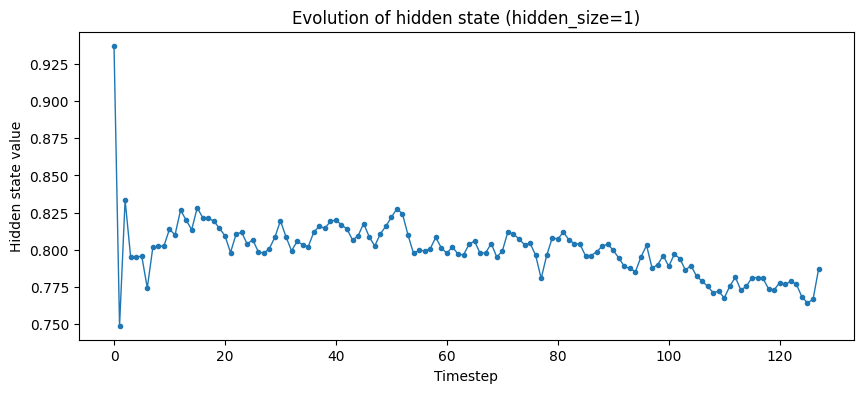

In [13]:
# Plot hidden state evolution across 128 timesteps
h_values = out_seq[:,0,0].detach().numpy()  # shape (128,)

plt.figure(figsize=(10,4))
plt.plot(range(128), h_values, marker='o', markersize=3, linewidth=1)
plt.xlabel("Timestep")
plt.ylabel("Hidden state value")
plt.title("Evolution of hidden state (hidden_size=1)")
plt.show()


**Reflection**

- With **hidden_size=1**, the RNN has just one “slot” of memory.  
- We saw how this scalar value changes step by step across the 128 timesteps.  
- At the end, the last hidden state $h_{128}$ was passed through a linear layer → logits → softmax → predicted activity.  

Even with just **one number**, the RNN is already doing something interesting: it is **accumulating evidence** from the entire sequence.  

Next, we will **increase the hidden size to 3**, so that instead of one scalar, the RNN carries a **3-dimensional memory vector** at each step.

---



### **5. Case 2 – Small Hidden Vector (batch=1, hidden_size=3)**

**Why increase hidden size?**

- With **hidden_size=1**, the RNN’s memory is just a single number → very limited capacity.  
- By increasing to **hidden_size=3**, the RNN now has a **3-dimensional hidden vector** at each timestep.  
- This gives the model **more capacity** to store and process different aspects of the temporal signal.  

Think of it as moving from:
- A notepad with **1 column** → only one number at a time.  
- To a notepad with **3 columns** → we can track multiple patterns simultaneously.  

**The RNN equations (vector case)**

At timestep $t$:

$$
h_t = \tanh(W_{xh} x_t + W_{hh} h_{t-1} + b_h)
$$

- Now $h_t \in \mathbb{R}^3$ (instead of $\mathbb{R}^1$).  
- Each of the 3 hidden units can learn to detect **different temporal patterns** in the signal.  

At the end:

$$
\hat{y} = \text{softmax}(W_{hy} h_{128} + b_y), \quad h_{128} \in \mathbb{R}^3
$$

**What we will do**

1. Reuse the same sequence from Case 1.  
2. Run it through an RNN with `hidden_size=3`.  
3. Print:  
   - shapes of `out_seq` and `h_n`  
   - a sample of hidden states across time  
   - the logits and softmax probabilities.  
4. Plot the **3 hidden dimensions** across 128 timesteps.



In [14]:
# Define RNN with hidden_size=3
rnn2 = nn.RNN(input_size=9, hidden_size=3, batch_first=False)

# Forward pass on same sequence
out_seq2, h_n2 = rnn2(seq_in)   # out_seq2: (128, 1, 3), h_n2: (1, 1, 3)

# Classification head: hidden -> 6 classes
fc2 = nn.Linear(3, NUM_CLASSES)
logits2 = fc2(h_n2.squeeze(0))   # shape (1,6)
probs2 = F.softmax(logits2, dim=1)

print("out_seq2 shape:", out_seq2.shape, "(seq_len=128, batch=1, hidden=3)")
print("h_n2 shape:", h_n2.shape, "(num_layers=1, batch=1, hidden=3)")
print("logits2 shape:", logits2.shape, "(1,6)")
print("probs2 shape:", probs2.shape, "(1,6)")


out_seq2 shape: torch.Size([128, 1, 3]) (seq_len=128, batch=1, hidden=3)
h_n2 shape: torch.Size([1, 1, 3]) (num_layers=1, batch=1, hidden=3)
logits2 shape: torch.Size([1, 6]) (1,6)
probs2 shape: torch.Size([1, 6]) (1,6)


In [15]:
# Inspect hidden states
print("First hidden state (3-dim):", out_seq2[0,0,:].detach().numpy())
print("Last hidden state (3-dim):", h_n2[0,0,:].detach().numpy())

First hidden state (3-dim): [-0.46551782 -0.17839776 -0.06331422]
Last hidden state (3-dim): [-0.20391817 -0.5176518  -0.2803582 ]


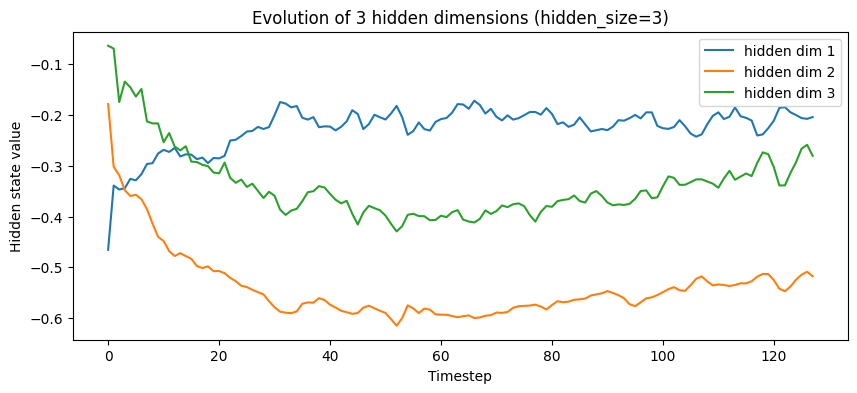

In [16]:
# Plot all 3 hidden dimensions over time
h_values2 = out_seq2[:,0,:].detach().numpy()  # shape (128,3)

plt.figure(figsize=(10,4))
for dim in range(3):
    plt.plot(range(128), h_values2[:,dim], label=f"hidden dim {dim+1}")
plt.xlabel("Timestep")
plt.ylabel("Hidden state value")
plt.title("Evolution of 3 hidden dimensions (hidden_size=3)")
plt.legend()
plt.show()



**Reflection**

- With **hidden_size=3**, each timestep’s hidden state is a **3D vector**.  
- The plot shows how each of the 3 hidden dimensions evolves differently across time.  
- Each dimension can specialize in detecting different aspects of the motion (e.g., oscillation, steady values, sharp changes).  

At the end:
- The **final hidden vector** $h_{128} \in \mathbb{R}^3$ is passed to the classifier.  
- This produces the logits and softmax probabilities over the 6 activities.  

➡️ Next, we will scale up to a **realistic batch setting (batch=32, hidden_size=32)** and see how RNNs handle multiple sequences in parallel.

---


Take a single sequence (128, 9), unsqueeze it to time-first shape (128, 1, 9), run it through an nn.RNN with hidden_size=6, and pass the final hidden state through a linear layer to produce (1, 6) class logits, then softmax to probabilities.


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# One sequence tensor from X_train_t (shape: 128,9)
CT_seq = X_train_t[0]                 # (128, 9)
CT_seq_in = CT_seq.unsqueeze(1)     # -> (128, 1, 9) time-first

# Define RNN and head
CT_rnn_bs1_h6 = nn.RNN(input_size=9, hidden_size=6, batch_first=False)
CT_fc_h6 = nn.Linear(6, NUM_CLASSES)

# Forward
CT_out_seq_bs1_h6, CT_hn_bs1_h6 = CT_rnn_bs1_h6(CT_seq_in)
CT_logits_bs1_h6 = CT_fc_h6(CT_hn_bs1_h6.squeeze(0))      # (1,6)
CT_probs_bs1_h6 = F.softmax(CT_logits_bs1_h6, dim=1)

print(CT_out_seq_bs1_h6.shape, CT_hn_bs1_h6.shape, CT_logits_bs1_h6.shape, CT_probs_bs1_h6.shape)

torch.Size([128, 1, 6]) torch.Size([1, 1, 6]) torch.Size([1, 6]) torch.Size([1, 6])


---

### **6. Case 3 – Realistic Batch (batch=32, hidden_size=32)**

**Why scale up?**

- So far, we used **batch=1** → easy to follow step by step, but not practical.  
- In training, we want to process **many sequences in parallel** to speed things up → **batch size > 1**.  
- Also, we want a hidden state with enough capacity to capture complex patterns → **hidden_size > 1**.  
- Here we’ll try `batch_size=32`, `hidden_size=32`.

**Time-first vs batch-first**

RNNs in PyTorch expect inputs in one of two formats:

- **Time-first (default):**  
  $(\text{seq\_len}, \text{batch}, \text{input\_size})$  
  Example: $(128, 32, 9)$  
  → At timestep 1, the RNN processes *all 32 sequences* in parallel.  

- **Batch-first (optional):**  
  $(\text{batch}, \text{seq\_len}, \text{input\_size})$  
  Example: $(32, 128, 9)$  
  → More intuitive (batch dimension comes first).  

We can choose either:
- Use **time-first** (default) and call `.permute(1,0,2)` to swap axes.  
- Or create the RNN with `batch_first=True`.  

**Intuition**

- In **time-first**, we conceptually “march through time” one step at a time, updating all sequences in the batch together.  
- In **batch-first**, we conceptually “line up full sequences” for each sample, then let the RNN handle the time loop internally.  
- Both are equivalent — it’s just about how we arrange the input tensor.

**What we will do**

1. Take a mini-batch of 32 sequences.  
2. Run them through an RNN with `hidden_size=32`.  
3. Print shapes:  
   - `out_seq` → all hidden states over time.  
   - `h_n` → final hidden state for each sequence.  
   - `logits` and `probs` → predictions.  
4. Inspect the first few predicted probability distributions.



In [18]:
# Create a batch of 32 sequences
batch_size = 32
X_batch = X_train_t[:batch_size]   # (32, 128, 9)
y_batch = y_train_t[:batch_size]   # (32,)

print("Batch shape (batch-first):", X_batch.shape)

# Convert to time-first for default RNN
X_batch_tf = X_batch.permute(1, 0, 2)   # (128, 32, 9)
print("Time-first shape:", X_batch_tf.shape)


Batch shape (batch-first): torch.Size([32, 128, 9])
Time-first shape: torch.Size([128, 32, 9])


In [19]:
# Define RNN with hidden_size=32
rnn3 = nn.RNN(input_size=9, hidden_size=32, batch_first=False)

# Forward pass
out_seq3, h_n3 = rnn3(X_batch_tf)   # out_seq3: (128, 32, 32), h_n3: (1, 32, 32)

# Classification head
fc3 = nn.Linear(32, NUM_CLASSES)
logits3 = fc3(h_n3.squeeze(0))   # (32,6)
probs3 = F.softmax(logits3, dim=1)

print("out_seq3 shape:", out_seq3.shape, "(seq_len=128, batch=32, hidden=32)")
print("h_n3 shape:", h_n3.shape, "(layers=1, batch=32, hidden=32)")
print("logits3 shape:", logits3.shape, "(batch=32, classes=6)")
print("probs3 sum per row (first):", probs3[0].sum().item())

out_seq3 shape: torch.Size([128, 32, 32]) (seq_len=128, batch=32, hidden=32)
h_n3 shape: torch.Size([1, 32, 32]) (layers=1, batch=32, hidden=32)
logits3 shape: torch.Size([32, 6]) (batch=32, classes=6)
probs3 sum per row (first): 1.0000001192092896


In [20]:
# Inspect first few probability distributions
for i in range(3):
    probs_row = probs3[i].detach().numpy()
    pred_idx = int(probs_row.argmax())
    print(f"Sample {i}: true={ACTIVITY_MAP[int(y_batch[i])+1]}, "
          f"pred={ACTIVITY_MAP[pred_idx+1]}, "
          f"probs={np.round(probs_row,3)}")


Sample 0: true=STANDING, pred=WALKING, probs=[0.201 0.18  0.165 0.135 0.16  0.159]
Sample 1: true=STANDING, pred=WALKING, probs=[0.202 0.182 0.164 0.138 0.159 0.155]
Sample 2: true=STANDING, pred=WALKING, probs=[0.202 0.182 0.164 0.138 0.159 0.155]


**Reflection**

- **Shapes:**  
  - `out_seq3`: all hidden states across 128 timesteps, for each sequence in the batch.  
  - `h_n3`: just the **last hidden state** for each sequence, used for classification.  
  - `logits3`: classifier outputs for all 32 sequences.  

- **Parallelization:** The RNN processed 32 sequences simultaneously.  
- **Hidden size:** With 32 dimensions, the hidden state can now capture richer, more nuanced temporal features.  
- **Predictions:** We saw softmax probabilities for each activity; the highest probability gives the predicted label.  

➡️ Next, we’ll clarify **what “hidden states vs predictions” mean** in sequence classification vs sequence labeling tasks.

---


📘 Instruction</br>
Build a mini-batch of 6 sequences (6, 128, 9), permute to time-first (128, 6, 9), feed it into an nn.RNN(hidden_size=6), and use the final hidden state from each sequence to get (6, 6) logits via a linear head; then compute softmax to check class probabilities.


In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Build a mini-batch (6,128,9) -> time-first (128,6,9)
CT_batch6 = X_train_t[:6]                        # (6,128,9)
CT_batch6_tf = CT_batch6.permute(1, 0, 2)   # -> (128,6,9)

CT_rnn_b6_h6 = nn.RNN(input_size=9, hidden_size=6, batch_first=False)
CT_fc_b6_h6 = nn.Linear(6, NUM_CLASSES)

CT_out_seq_b6, CT_hn_b6 = CT_rnn_b6_h6(CT_batch6_tf)  # (128,6,6), (1,6,6)
CT_logits_b6_h6 = CT_fc_b6_h6(CT_hn_b6.squeeze(0))    # (6,6)
CT_probs_b6_h6 = F.softmax(CT_logits_b6_h6, dim=1)

print(CT_out_seq_b6.shape, CT_hn_b6.shape, CT_logits_b6_h6.shape, CT_probs_b6_h6.shape)

torch.Size([128, 6, 6]) torch.Size([1, 6, 6]) torch.Size([6, 6]) torch.Size([6, 6])


📘 Instruction</br>
Implement two helper functions: one that converts (B, T, F) → (T, B, F) and another that converts back, using permute. We then verify shapes on a dummy tensor and confirm a round-trip returns the original tensor.


In [22]:
import torch

def CT_to_time_first(x_btf):
    """
    x_btf: (B, T, F) -> return (T, B, F)
    """
    assert x_btf.ndim == 3, "x_btf must be 3D (B,T,F)"
    return x_btf.permute(1, 0, 2)

def CT_to_batch_first(x_tbf):
    """
    x_tbf: (T, B, F) -> return (B, T, F)
    """
    assert x_tbf.ndim == 3, "x_tbf must be 3D (T,B,F)"
    return x_tbf.permute(1, 0, 2)

# Quick self-check on a dummy tensor
CT_dummy = torch.zeros(4, 128, 9)   # (B,T,F)
CT_tfirst = CT_to_time_first(CT_dummy)
CT_back   = CT_to_batch_first(CT_tfirst)

print("Shapes:", CT_dummy.shape, "->", CT_tfirst.shape, "->", CT_back.shape)


Shapes: torch.Size([4, 128, 9]) -> torch.Size([128, 4, 9]) -> torch.Size([4, 128, 9])


---

### **7. Hidden States vs Predictions**

**Two ways RNNs can be used**

An RNN produces a hidden state $h_t$ at **every timestep $t$**.  
From each $h_t$, we can also produce a prediction $\hat{y}_t$.

So we need to ask: **Do we want one prediction per sequence, or one prediction per timestep?**

**Sequence classification (our case: HAR)**

- Input: a window of **128 timesteps × 9 features**.  
- Output: **1 activity label** for the whole window.  
- Method:  
  - We only take the **last hidden state** $h_{128}$.  
  - Pass it through a classifier (linear layer + softmax).  
  - One probability distribution over the 6 activities.  

Formally:

$$
\hat{y} = \text{softmax}(W_{hy} h_{128} + b_y)
$$


**Sequence labeling (other tasks)**

- Example: Part-of-Speech tagging in NLP, speech recognition, gesture recognition.  
- Input: a sequence of tokens/sounds/frames.  
- Output: **one label for each timestep**.  
- Method:  
  - Use every $h_t$.  
  - Classifier produces $\hat{y}_t$ for each $t$.  

Formally:

$$
\hat{y}_t = \text{softmax}(W_{hy} h_t + b_y), \quad t=1,\ldots,128
$$

**Visualization**

Think of it this way:

- **Sequence classification (HAR):**  
  Sequence of hidden states $h_1, h_2, \ldots, h_{128}$ → only last $h_{128}$ used → one label.  

- **Sequence labeling (e.g., POS tagging):**  
  Sequence of hidden states $h_1, h_2, \ldots, h_{128}$ → each $h_t$ → label $\hat{y}_t$.  

**Reflection**

- For **HAR**, the dataset labels each 2.56-second window with **one activity**, so sequence classification is appropriate.  
- If instead we had **frame-by-frame labels**, we would need sequence labeling.  

➡️ This distinction prepares us for understanding **how RNN outputs are used differently** in various tasks.



In [23]:
# Using out_seq3 from Section 5 (shape: 128, 32, 32)

# Sequence classification: use only last hidden state
last_hidden = h_n3.squeeze(0)        # shape (32, 32)
logits_cls = fc3(last_hidden)        # shape (32,6)

# Sequence labeling: use all hidden states
out_seq_flat = out_seq3.reshape(-1, 32)  # (128*32, 32)
logits_lbl = fc3(out_seq_flat)           # (128*32, 6)

print("Classification logits shape:", logits_cls.shape, "(batch=32, classes=6)")
print("Labeling logits shape:", logits_lbl.shape, "(timesteps*batch, classes=6)")

Classification logits shape: torch.Size([32, 6]) (batch=32, classes=6)
Labeling logits shape: torch.Size([4096, 6]) (timesteps*batch, classes=6)


📘 Instruction</br>
Demonstrate the difference between:
- Sequence classification: use only the last hidden state (6, 6) to get per-sequence logits (6, 6).
- Sequence labeling: use all time steps, flatten hidden states (128*6, 6), and map each timestep to logits (128*6, 6)—i.e., a label per timestep.


In [24]:
# Using: CT_out_seq_b6 (128,6,6), CT_hn_b6 (1,6,6), CT_fc_b6_h6

# (A) Sequence classification: last hidden only
CT_last_hidden_b6 = CT_hn_b6.squeeze(0)           # squeeze layer dim -> (6,6)
CT_logits_cls_b6 = CT_fc_b6_h6(CT_last_hidden_b6)            # (6,6)

# (B) Sequence labeling: use all hidden states
CT_out_seq_flat_b6 = CT_out_seq_b6.reshape(-1, 6)          # reshape to (128*6, 6)
CT_logits_lbl_b6 = CT_fc_b6_h6(CT_out_seq_flat_b6)            # (128*6, 6)

print("cls:", getattr(CT_logits_cls_b6, "shape", None), 
      "lbl:", getattr(CT_logits_lbl_b6, "shape", None))


cls: torch.Size([6, 6]) lbl: torch.Size([768, 6])


---

### **8. Summary & Bridge to NB02**

**Key lessons from this notebook**

- **Sequential data matters**:  
  The raw inertial signals from the HAR dataset are **time series** — 128 timesteps × 9 features.  
  Preserving this order is essential because the sequence tells the story of the movement.  

- **RNN mechanics**:  
  - At each timestep, the RNN updates a **hidden state $h_t$** using the new input $x_t$ and the previous hidden state $h_{t-1}$.  
  - This hidden state acts as a **memory**, carrying forward information.  
  - At the end, we use the last hidden state $h_{128}$ to classify the activity.  

- **Batch size**: how many sequences we process in parallel.  
- **Hidden size**: the “capacity” of the RNN’s memory (number of hidden units).  

- **Shapes we encountered**:  
  - Inputs: $(\text{seq\_len}, \text{batch}, \text{input\_size})$  
  - Hidden states: $(\text{layers}, \text{batch}, \text{hidden\_size})$  
  - Outputs: $(\text{seq\_len}, \text{batch}, \text{hidden\_size})$  
  - Logits: $(\text{batch}, \text{num\_classes})$  

- **Case studies we explored**:  
  - Case 1: batch=1, hidden_size=1 → simplest scalar hidden state, easy to visualize.  
  - Case 2: batch=1, hidden_size=3 → multiple hidden dimensions evolving differently.  
  - Case 3: batch=32, hidden_size=32 → realistic training setup, parallel sequences, richer memory.  

- **Time-first vs Batch-first**:  
  - Time-first = default in PyTorch → $(128, 32, 9)$.  
  - Batch-first = often more intuitive → $(32, 128, 9)$.  
  - Both are equivalent; we just need to be consistent.  

- **Hidden states vs predictions**:  
  - HAR is **sequence classification** → one label per sequence.  
  - Some tasks are **sequence labeling** → one label per timestep.

**Looking ahead to Notebook 2**

In the next notebook, we will:

1. **Build and train an RNN classifier** on the HAR dataset.  
2. Compare it against a simple **MLP-on-flattened-sequence baseline**.  
3. Visualize training curves and confusion matrices.  
4. Reflect on why RNNs perform better when the temporal structure matters.  

**Reflection**

So far, we have built intuition about:
- What RNNs are,  
- How they process sequences,  
- Why hidden states are important,  
- And how input/output shapes connect.  

We are now ready to move from **understanding mechanics** → to **training models that actually recognize activities**.

